<a href="https://colab.research.google.com/github/deybvagm/invoice-object-detection/blob/master/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making predictions on trained models

This notebook is intended to take two pretrained models, faster RCNN and SSD and perform object detection to detect header, date and total info in a given invoice

The notebook is divided in two parts:
- Part 1 for environment configuration, i.e, Tensorflow Object Detection API on colab
- Part 2 in which you can make predictions on your own images

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import imutils
import os
import cv2


In [0]:
tf.__version__

## Environment configuration

Here we need install tensorflow object detection API but also configure some things for making ppredictions on invoices


### Dependencies

We need:
- Tensorflow object detection API: For this we are going to clone the repository
- We need to install some needed packages in the system
- We need compile object detection API

In [0]:
!git clone https://github.com/tensorflow/models.git

In [0]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython

In [0]:
%cd '/content/models/'
!git checkout c9f03bf6a8ae58b9ead119796a6c3cd9bd04d450
!wget https://github.com/deybvagm/invoice-object-detection/raw/master/fixes.zip
!unzip fixes.zip
!mv fixes/*.py '/content/models/research/object_detection/'

In [0]:
# compile model definition
%cd '/content/models/research/'
!protoc object_detection/protos/*.proto --python_out=.

In [0]:
# set the environment
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim'

In [0]:
!python setup.py build
!python setup.py install

In [0]:
# to test if everything is ok
!python /content/models/research/object_detection/builders/model_builder_test.py

In [0]:
# create a symbolic link to avoid writting complete paths
%cd '/content/'
!ln -s '/content/models/research/object_detection/' object_detection

In [0]:
from object_detection.utils import label_map_util

### Configuring invoice environment

Here we are going to download the images for prediction, configure a file with the info about classes required by the API and define a function to make predictions on new images

In [0]:
!git clone https://github.com/deybvagm/invoice-object-detection.git
!mv invoice-object-detection invoice

In [0]:
def predict(model_path, labels_path, img_path, num_classes=3, min_confidence=0.5):
  # initialize a set of colors for our class labels
  COLORS = np.random.uniform(0, 255, size=(num_classes, 3))

  # initialize the model
  model = tf.Graph()

  # create a context manager that makes this model the default one for
  # execution
  with model.as_default():
    # initialize the graph definition
    graphDef = tf.GraphDef()

    # load the graph from disk
    with tf.gfile.GFile(model_path, "rb") as f:
      serializedGraph = f.read()
      graphDef.ParseFromString(serializedGraph)
      tf.import_graph_def(graphDef, name="")

  # load the class labels from disk
  labelMap = label_map_util.load_labelmap(labels_path)
  categories = label_map_util.convert_label_map_to_categories(labelMap, max_num_classes=num_classes,use_display_name=True)
  categoryIdx = label_map_util.create_category_index(categories)

  # create a session to perform inference
  with model.as_default():
    with tf.Session(graph=model) as sess:
      # grab a reference to the input image tensor and the boxes
      # tensor
      imageTensor = model.get_tensor_by_name("image_tensor:0")
      boxesTensor = model.get_tensor_by_name("detection_boxes:0")

      # for each bounding box we would like to know the score
      # (i.e., probability) and class label
      scoresTensor = model.get_tensor_by_name("detection_scores:0")
      classesTensor = model.get_tensor_by_name("detection_classes:0")
      numDetections = model.get_tensor_by_name("num_detections:0")

      # load the image from disk
      image = cv2.imread(img_path)
      (H, W) = image.shape[:2]

      # check to see if we should resize along the width
      if W > H and W > 1000:
        image = imutils.resize(image, width=1000)

      # otherwise, check to see if we should resize along the
      # height
      elif H > W and H > 1000:
        image = imutils.resize(image, height=1000)

      # prepare the image for detection
      (H, W) = image.shape[:2]
      output = image.copy()
      # cv2.namedWindow("Output", cv2.WINDOW_NORMAL)
      image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
      image = np.expand_dims(image, axis=0)

  # perform inference and compute the bounding boxes,
      # probabilities, and class labels
      (boxes, scores, labels, N) = sess.run([boxesTensor, scoresTensor, classesTensor, numDetections],feed_dict={imageTensor: image})

      # squeeze the lists into a single dimension
      boxes = np.squeeze(boxes)
      scores = np.squeeze(scores)
      labels = np.squeeze(labels)

      # loop over the bounding box predictions
      for (box, score, label) in zip(boxes, scores, labels):
        # if the predicted probability is less than the minimum
        # confidence, ignore it
        if score < min_confidence:
          continue

        # scale the bounding box from the range [0, 1] to [W, H]
        (startY, startX, endY, endX) = box
        startX = int(startX * W)
        startY = int(startY * H)
        endX = int(endX * W)
        endY = int(endY * H)

        # draw the prediction on the output image
        label = categoryIdx[label]
        idx = int(label["id"]) - 1
        label = "{}: {:.2f}".format(label["name"], score)
        cv2.rectangle(output, (startX, startY), (endX, endY),
        COLORS[idx], 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(output, label, (startX, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.3, COLORS[idx], 1)
      
      # show the output image
  plt.figure(figsize=(6,15))
  # ax = plt.subplot(111)
  plt.imshow(output, interpolation='nearest', aspect='auto')


In [0]:
%%writefile /content/invoice/classes.pbtxt
item {
	id: 1
	name: 'header'
}
item {
	id: 2
	name: 'date'
}
item {
	id: 3
	name: 'total'
}

Writing /content/invoice/classes.pbtxt


## Predictions

This section downloads the pretrained models for faster RCNN and SSD to make predictions on new images

### Dowloading pretrained models

Here we download some pretrained models using faster RCNN and SSD.

In [0]:
# Loading pretrained model
!mkdir '/content/invoice/rcnn/'
!mkdir '/content/invoice/ssd/'
!wget https://invoiceproject.s3-us-west-2.amazonaws.com/faster_rcnn_exported_model.tar.gz
!wget https://invoiceproject.s3-us-west-2.amazonaws.com/ssd_exported_model.tar.gz

!mv faster_rcnn_exported_model.tar.gz '/content/invoice/rcnn/'
!mv ssd_exported_model.tar.gz '/content/invoice/ssd/'

%cd '/content/invoice/rcnn/'
!tar -zxvf faster_rcnn_exported_model.tar.gz
%cd '/content/invoice/ssd/'
!tar -zxvf ssd_exported_model.tar.gz

### Making predictions with SDD model


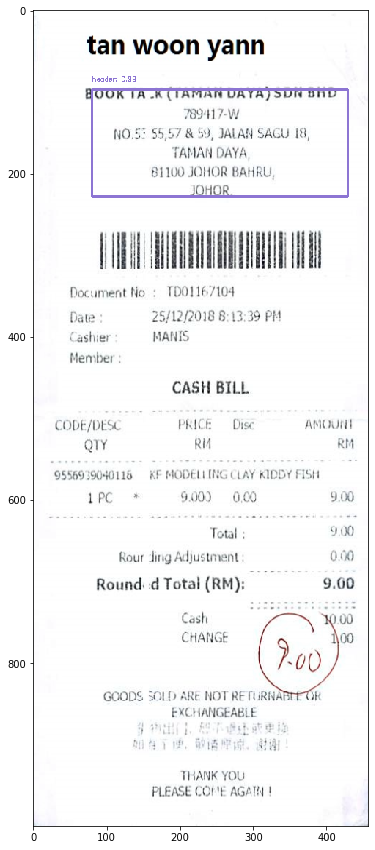

In [0]:
path_to_model = '/content/invoice/ssd/exported_model/frozen_inference_graph.pb'
path_to_labels = '/content/invoice/classes.pbtxt'
path_to_img = '/content/invoice/sample_imgs/X00016469612.jpg'
predict(path_to_model, path_to_labels, path_to_img)

### Making predictions with Faster RCNN

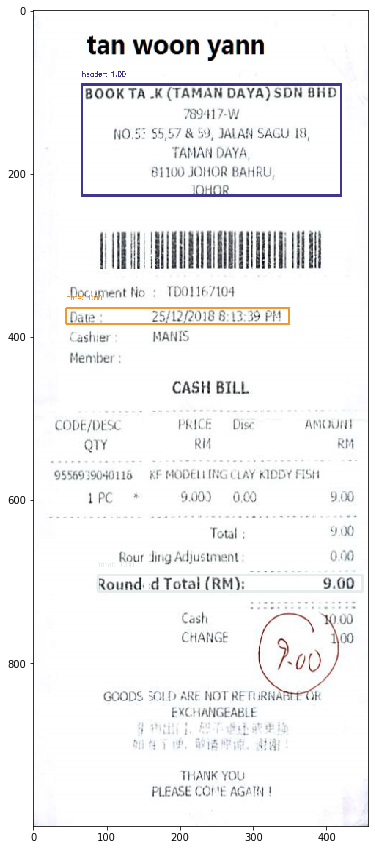

In [0]:
path_to_model = '/content/invoice/rcnn/exported_model/frozen_inference_graph.pb'
path_to_labels = '/content/invoice/classes.pbtxt'
path_to_img = '/content/invoice/sample_imgs/X00016469612.jpg'
predict(path_to_model, path_to_labels, path_to_img)

### Making predictions with unseen images
In this case we are going to test the model with invoices from some stores in Colombia

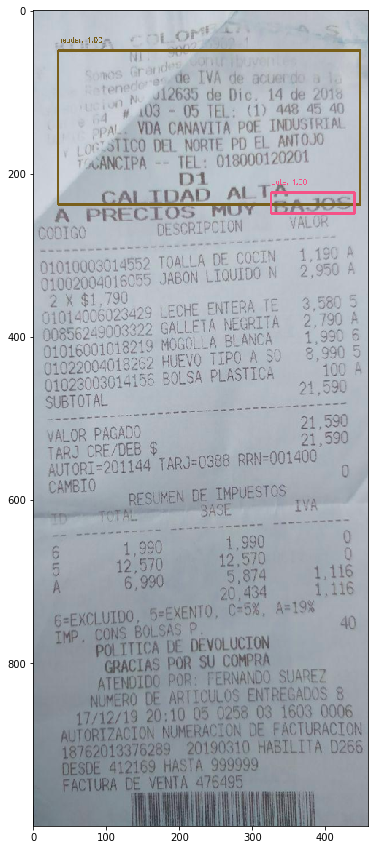

In [0]:
path_to_model = '/content/invoice/rcnn/exported_model/frozen_inference_graph.pb'
path_to_labels = '/content/invoice/classes.pbtxt'
path_to_img = '/content/invoice/sample_imgs/d1.jpg'
predict(path_to_model, path_to_labels, path_to_img)

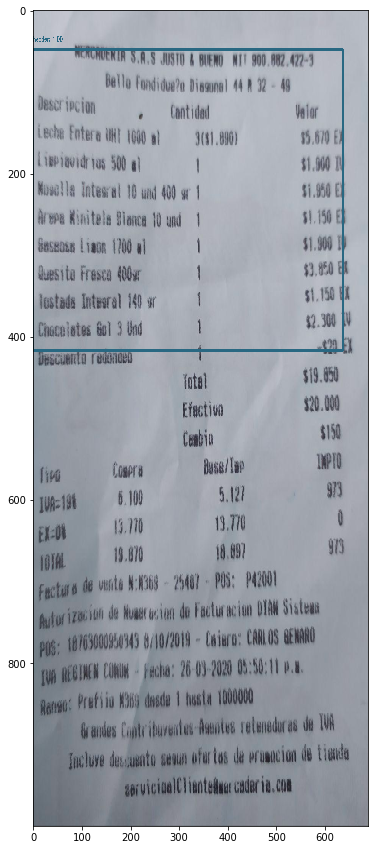

In [0]:
path_to_model = '/content/invoice/rcnn/exported_model/frozen_inference_graph.pb'
path_to_labels = '/content/invoice/classes.pbtxt'
path_to_img = '/content/invoice/sample_imgs/jyb.jpg'
predict(path_to_model, path_to_labels, path_to_img)

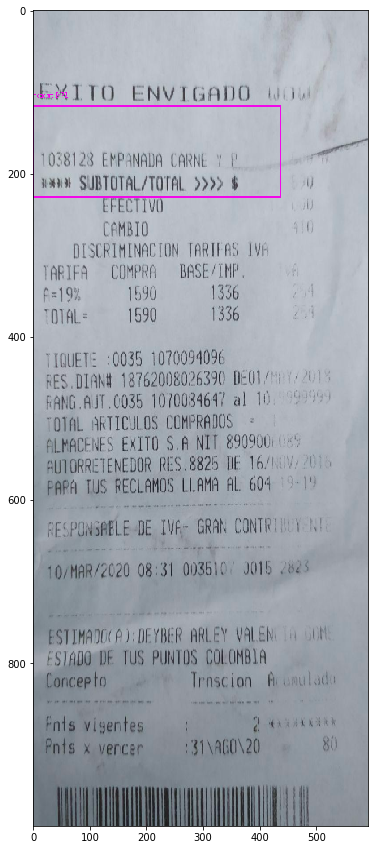

In [0]:
path_to_model = '/content/invoice/ssd/exported_model/frozen_inference_graph.pb'
path_to_labels = '/content/invoice/classes.pbtxt'
path_to_img = '/content/invoice/sample_imgs/exito.jpg'
predict(path_to_model, path_to_labels, path_to_img)